<a href="https://colab.research.google.com/github/harim4422/tensorflow2_deeplearning/blob/master/q_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
import numpy as np
print(tf.__version__)

2.2.0-rc1


In [2]:
!pip install gym pyvirtualdisplay
!apt-get install -y xvfb python-opengl ffmpeg

!apt-get update
!apt-get install cmake
!pip install --upgrade setuptools
!pip install ez_setup
!pip install gym[atari]

!pip install box2d-py
!pip install gym[Box_2D]

Reading package lists... Done
Building dependency tree       
Reading state information... Done
ffmpeg is already the newest version (7:3.4.6-0ubuntu0.18.04.1).
Suggested packages:
  libgle3
The following NEW packages will be installed:
  python-opengl xvfb
0 upgraded, 2 newly installed, 0 to remove and 25 not upgraded.
Need to get 1,280 kB of archives.
After this operation, 7,682 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 python-opengl all 3.1.0+dfsg-1 [496 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic-updates/universe amd64 xvfb amd64 2:1.19.6-1ubuntu4.4 [784 kB]
Fetched 1,280 kB in 3s (460 kB/s)
Selecting previously unselected package python-opengl.
(Reading database ... 144542 files and directories currently installed.)
Preparing to unpack .../python-opengl_3.1.0+dfsg-1_all.deb ...
Unpacking python-opengl (3.1.0+dfsg-1) ...
Selecting previously unselected package xvfb.
Preparing to unpack .../xvfb_2%3a1.19.6-1ubuntu4.4

  Created wheel for ez-setup: filename=ez_setup-0.9-cp36-none-any.whl size=11015 sha256=c7f72fda153907035b16975ce6c7cfc764259b6fe1e6b221f9664982ebb61c0c
  Stored in directory: /root/.cache/pip/wheels/dc/e8/6b/3d5ff5a3efd7b5338d1e173ac981771e2628ceb2f7866d49ad
Successfully built ez-setup
     |████████████████████████████████| 450kB 38.9MB/s 


In [3]:
# env.render() 함수의 결과를 mp4 동영상으로 보여주기 위한 코드
# from https://colab.research.google.com/drive/1flu31ulJlgiRL1dnN2ir8wGh9p7Zij2t
from gym import logger as gymlogger
from gym.wrappers import Monitor
gymlogger.set_level(40) #error only
import glob
import io
import base64
from IPython.display import HTML
from IPython import display as ipythondisplay

"""
Utility functions to enable video recording of gym environment and displaying it
To enable video, just do "env = wrap_env(env)""
"""

def show_video():
    mp4list = glob.glob('video/*.mp4')
    if len(mp4list) > 0:
        mp4 = mp4list[0]
        video = io.open(mp4, 'r+b').read()
        encoded = base64.b64encode(video)
        ipythondisplay.display(HTML(data='''<video alt="test" autoplay 
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
    else: 
        print("Could not find video")
    

def wrap_env(env):
    env = Monitor(env, './video', force=True)
    return env
  
from pyvirtualdisplay import Display
display = Display(visible=0, size=(1400, 900))
display.start()

xdpyinfo was not found, X start can not be checked! Please install xdpyinfo!


<Display cmd_param=['Xvfb', '-br', '-nolisten', 'tcp', '-screen', '0', '1400x900x24', ':1001'] cmd=['Xvfb', '-br', '-nolisten', 'tcp', '-screen', '0', '1400x900x24', ':1001'] oserror=None return_code=None stdout="None" stderr="None" timeout_happened=False>

In [5]:
import gym
# MountainCarContinuous-v0 환경 만들기
env = gym.make('MountainCarContinuous-v0')

print(env.observation_space)
print(env.observation_space.low)
print(env.observation_space.high)
print()
print(env.action_space)
print(env.action_space.low)
print(env.action_space.high)
print()
print(env._max_episode_steps)

Box(2,)
[-1.2  -0.07]
[0.6  0.07]

Box(1,)
[-1.]
[1.]

999


In [6]:
# 관찰 공간과 행동 공간을 격자화
state_grid_count = 10
action_grid_count = 6

q_table = []
for i in range(state_grid_count):
    q_table.append([])
    for j in range(state_grid_count):
        q_table[i].append([])
        for k in range(action_grid_count):
            q_table[i][j].append(1e-4)
            
actions = range(action_grid_count)
actions = np.array(actions).astype(float)
actions *= ((env.action_space.high - env.action_space.low) / (action_grid_count - 1))
actions += env.action_space.low

print(actions)

[-1.         -0.59999999 -0.19999999  0.20000002  0.60000002  1.00000003]


In [0]:
# obs_to_state, softmax 함수 정의
import random
def obs_to_state(env, obs):
    obs = obs.flatten()
    low = env.observation_space.low
    high = env.observation_space.high
    idx = (obs - low) / (high - low) * state_grid_count
    idx = [int(x) for x in idx]
    return idx

def softmax(logits):
    exp_logits = np.exp(logits - np.max(logits))
    sum_exp_logits = np.sum(exp_logits)
    return exp_logits / sum_exp_logits

In [8]:
# 큐러닝 에이전트 학습
max_episodes = 10000
scores = []
steps = []
select_actions = []

learning_rate = 0.05
gamma = 0.99
epsilon = 1.0
epsilon_min = 0.01

for i in range(max_episodes):
    epsilon *= 0.9
    epsilon = max(epsilon_min, epsilon)
    
    if i % 100 == 0 and i != 0:
        print(i, 'mean score: {}, mean step: {}, epsilon: {}'.format(np.mean(scores[-100:]), np.mean(steps[-100:]), epsilon))
        
    previous_obs = env.reset()
    score = 0
    step = 0
    
    while True:
        state_idx = obs_to_state(env, previous_obs)
        if random.random() < epsilon:
            action_idx = random.randint(0, action_grid_count-1)
            action = actions[action_idx]
        else:
            logits = q_table[state_idx[0]][state_idx[1]]
            action_idx = np.argmax(softmax(logits))
            action = actions[action_idx]
        
        obs, reward, done, info = env.step([action])
        previous_obs = obs
        score += reward
        reward -= 0.05
        step += 1
        
        select_actions.append(action)
        
        new_state_idx = obs_to_state(env, obs)
        
        q_table[state_idx[0]][state_idx[1]][action_idx] = \
            q_table[state_idx[0]][state_idx[1]][action_idx] + \
            learning_rate * (reward + gamma * np.amax(q_table[new_state_idx[0]][new_state_idx[1]]) - q_table[state_idx[0]][state_idx[1]][action_idx])
        
        if done:
            break
    
    scores.append(score)   
    steps.append(step)
    
    if np.mean(scores[-100:]) >= 90:
        print('Solved on episode {}!'.format(i))
        break

100 mean score: -15.488960905148929, mean step: 967.44, epsilon: 0.01
200 mean score: 76.51815930217748, mean step: 464.14, epsilon: 0.01
300 mean score: 87.97811936203718, mean step: 314.03, epsilon: 0.01
400 mean score: 89.97639945682286, mean step: 342.54, epsilon: 0.01
Solved on episode 400!


59.824388331971576


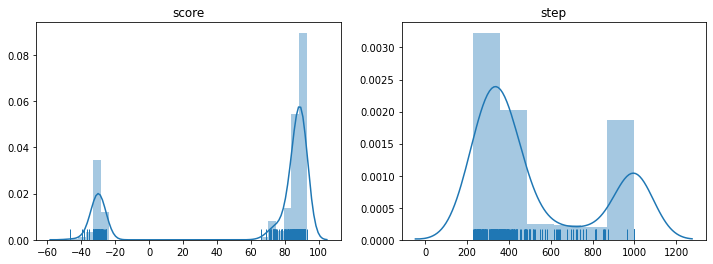

In [10]:
# score, step 분포 확인
import matplotlib.pyplot as plt
import seaborn as sns

fig, ax = plt.subplots(1, 2, figsize=(12, 4))
ax[0].set_title('score')
ax[1].set_title('step')
sns.distplot(scores, rug=True, ax=ax[0])
sns.distplot(steps, rug=True, ax=ax[1])

print(np.mean(scores))

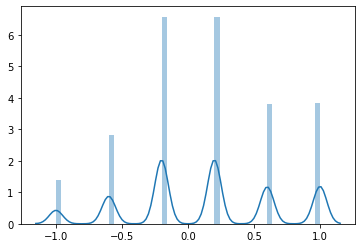

In [11]:
# 행동 분포 확인
sns.distplot(select_actions)

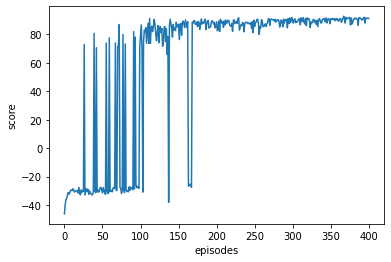

In [12]:
# score 그래프
plt.plot(scores)
plt.xlabel('episodes')
plt.ylabel('score')
plt.show()

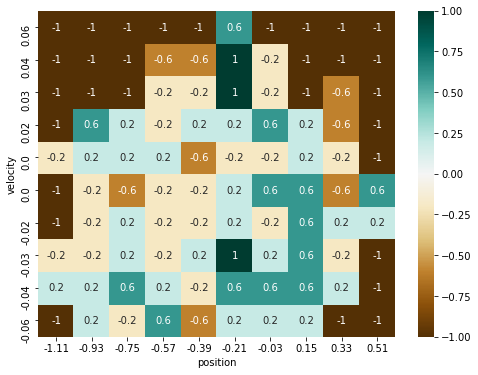

In [13]:
# 큐테이블 시각화
q_values = []
for i in range(state_grid_count):
    q_values.append([])
    for j in range(state_grid_count):
        action_idx = np.argmax(q_table[i][j])
        q_values[i].append(actions[action_idx])

plt.figure(figsize=(8, 6))
ax = sns.heatmap(q_values, annot=True, cmap='BrBG')
ax.set_xlabel('position')
ax.set_ylabel('velocity')
xticks = env.observation_space.low[0] + range(state_grid_count+1) * abs((env.observation_space.high[0] - env.observation_space.low[0]) / state_grid_count)
xticks = [int((xticks[idx] + xticks[idx+1]) / 2 * 100) / 100 for idx, xtick in enumerate(xticks[:-1])]
ax.set_xticklabels(xticks)
yticks = env.observation_space.low[1] + range(state_grid_count+1) * abs((env.observation_space.high[1] - env.observation_space.low[1]) / state_grid_count)
yticks = [int((yticks[idx] + yticks[idx+1]) / 2 * 100) / 100 for idx, ytick in enumerate(yticks[:-1])]
ax.set_yticklabels(yticks)
ax.invert_yaxis()
plt.show()

In [14]:
# 큐러닝 에이전트 실행 결과 확인
env.close()
env = wrap_env(gym.make('MountainCarContinuous-v0'))

score = 0
step = 0
previous_obs = env.reset()

while True:
    state_idx = obs_to_state(env, previous_obs)
    if random.random() < epsilon:
        action_idx = random.randint(0, action_grid_count-1)
        action = actions[action_idx]
    else:
        logits = q_table[state_idx[0]][state_idx[1]]
        action_idx = np.argmax(softmax(logits))
        action = actions[action_idx]

    obs, reward, done, info = env.step([action])
    previous_obs = obs
    score += reward
    step += 1
    
    if done:
        break

print('score:', score)
print('step:', step)
env.close()
show_video()

score: 91.95599955940244
step: 387
